**GOALS**:
- Explore data
- Extract features to build classification models

***

 To do so, I've read this [awesome kernel](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction) which gives many simple insights on the data content and [this one](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) which led to this [github code](https://github.com/js-aguiar/home-credit-default-competition/blob/master/README.md).

 The goal of this project is not to focus on the refinement of the cleansing nor the feature engineering but rather to focus on the MLOps part (models tracking and deployment, API for inference, and dashboard).
 
 Thus, I extracted features into pickle files thanks to Aguiar's github script that I've slightly adapted to my pandas version.

 This notebook helps to discover briefly these features and get a sense of what Aguiar did observing results while reading through corresponding functions.

 Finally, it merges everything into one usable compressed csv.gz file.
 
  

**Table of contents**<a id='toc0_'></a>    
- 1. [Paths](#toc1_)    
- 2. [Original Features descriptions in the tables](#toc2_)    
- 3. [Distribution of the target](#toc3_)    
- 4. [Read feature dataframes](#toc4_)    
- 5. [Explore engineered features](#toc5_)    
  - 5.1. [Bureau and balance](#toc5_1_)    
  - 5.2. [Application](#toc5_2_)    
  - 5.3. [Previous](#toc5_3_)    
  - 5.4. [Pos_cash](#toc5_4_)    
  - 5.5. [Payments](#toc5_5_)    
  - 5.6. [Credit_card](#toc5_6_)    
- 6. [Merge features](#toc6_)    
- 7. [Nulls quick exploration](#toc7_)    
- 8. [Add extra ratio features](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import missingno as msno
import gc

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Paths

In [2]:
APPLICATION_TRAIN_PATH = './data/application_train.csv'
APPLICATION_TEST_PATH = './data/application_test.csv'
BUREAU_PATH = './data/bureau.csv'
BUREAU_BALANCE_PATH = './data/bureau_balance.csv'
CREDIT_CARD_BALANCE_PATH = './data/credit_card_balance.csv'
INSTALLMENTS_PAYMENTS_PATH = './data/installments_payments.csv'
PREVIOUS_APPLICATION_PATH = './data/previous_application.csv'
SAMPLE_SUBMISSION_PATH = './data/sample_submission.csv'
POS_CASH_BALANCE_PATH = './data/POS_CASH_balance.csv'
COLUMNS_DESCRIPTION_PATH = './data/HomeCredit_columns_description.csv'

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Original Features descriptions in the tables

In [3]:
desc_df = pd.read_csv(
    COLUMNS_DESCRIPTION_PATH,
    index_col=0,
    encoding_errors='ignore',
)

desc_df.head()

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [22]:
for table_name in desc_df.Table.unique():
    print(f"\n### TABLE NAME : {table_name} ###\n")
    df = desc_df.query('Table == @table_name')
    for index, row in df.drop(['Table', 'Special'], axis=1).iterrows():
        print('{:>30} : {} '.format(row.Row, row.Description))
    


### TABLE NAME : application_{train|test}.csv ###

                    SK_ID_CURR : ID of loan in our sample 
                        TARGET : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) 
            NAME_CONTRACT_TYPE : Identification if loan is cash or revolving 
                   CODE_GENDER : Gender of the client 
                  FLAG_OWN_CAR : Flag if the client owns a car 
               FLAG_OWN_REALTY : Flag if client owns a house or flat 
                  CNT_CHILDREN : Number of children the client has 
              AMT_INCOME_TOTAL : Income of the client 
                    AMT_CREDIT : Credit amount of the loan 
                   AMT_ANNUITY : Loan annuity 
               AMT_GOODS_PRICE : For consumer loans it is the price of the goods for which the loan is given 
               NAME_TYPE_SUITE : Who was accompanying client

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Distribution of the target

In [32]:
df = pd.read_csv(APPLICATION_TRAIN_PATH)
df.shape

(307511, 122)

In [38]:
df.TARGET.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

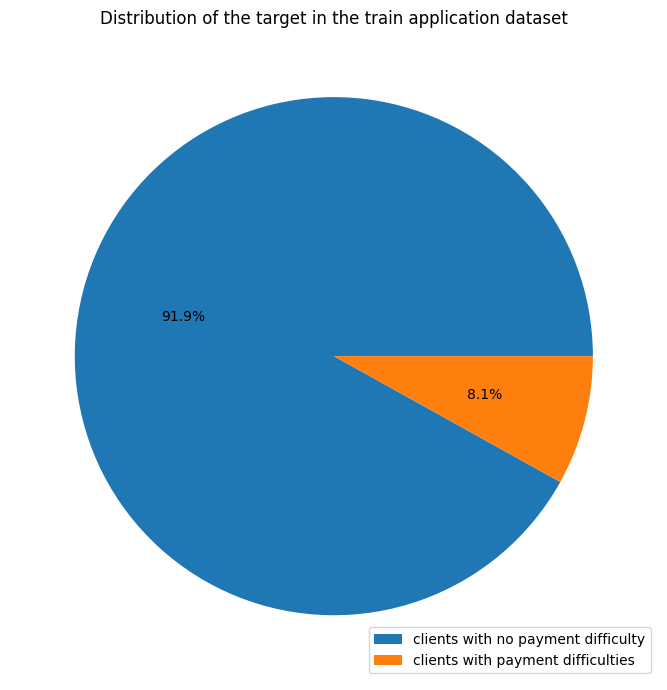

In [66]:
labels = ['clients with no payment difficulty', 'clients with payment difficulties']

fig = plt.figure(figsize=(7,7))
plt.pie(df.TARGET.value_counts().values, labels=None, autopct='%1.1f%%')
plt.legend(labels, loc="lower right")
plt.title("Distribution of the target in the train application dataset")
plt.tight_layout()
plt.show()

This is an unbalanced classification problem

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Read feature dataframes

In [3]:
PICKLE_FILES_PATHS = glob.glob('./pickle_files/*')
PICKLE_FILES_PATHS

['./pickle_files/bureau_and_balance.pkl',
 './pickle_files/payments.pkl',
 './pickle_files/credit_card.pkl',
 './pickle_files/previous.pkl',
 './pickle_files/pos_cash.pkl',
 './pickle_files/application.pkl']

In [4]:
df_names = [path.split('/')[-1].removesuffix('.pkl') 
            for path in PICKLE_FILES_PATHS]
df_names

['bureau_and_balance',
 'payments',
 'credit_card',
 'previous',
 'pos_cash',
 'application']

In [5]:
for path, df_name in zip(PICKLE_FILES_PATHS, df_names):
    print(df_name)
    exec(f"{df_name} = pd.read_pickle('{path}')")
    print(eval(df_name).shape)

bureau_and_balance
(305811, 173)
payments
(339587, 101)
credit_card
(103558, 59)
previous
(338857, 242)
pos_cash
(337252, 24)
application
(356250, 124)


# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Explore engineered features

## 5.1.  [&#9650;](#toc0_) <a id='toc5_1_'></a>Bureau and balance

In [21]:
bureau_and_balance.head()

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,...,BUREAU_LAST36M_AMT_CREDIT_SUM_SUM,BUREAU_LAST36M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST36M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST36M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST36M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST36M_STATUS_0_MEAN,BUREAU_LAST36M_STATUS_12345_MEAN,AMT_CREDIT_MAX_OVERDUE,BUREAU_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEBT_OVER_CREDIT
0,100001,7,-1572,-49,-735.000,-1329.0,1778.0,NaN,NaN,378000.000000,...,1.367865e+06,99447.75,596686.5,NaN,128529.750000,0.389648,0.008774,NaN,0.410555,0.674966
1,100002,8,-1437,-103,-874.000,-1072.0,780.0,5043.64502,1681.029053,450000.000000,...,6.702236e+05,61445.25,245781.0,NaN,89235.640625,0.362549,0.250000,40.5,0.284122,0.509931
2,100003,4,-2586,-606,-1401.000,-2434.0,1216.0,0.00000,0.000000,810000.000000,...,8.826525e+05,0.00,0.0,NaN,441326.250000,NaN,NaN,0.0,0.000000,0.000000
3,100004,2,-1326,-408,-867.000,-595.0,-382.0,0.00000,0.000000,94537.796875,...,9.453780e+04,0.00,0.0,inf,94537.796875,NaN,NaN,0.0,0.000000,NaN
4,100005,3,-373,-62,-190.625,-128.0,1324.0,0.00000,0.000000,568800.000000,...,6.571260e+05,189469.50,568408.5,NaN,29572.500000,0.734863,0.000000,0.0,0.864992,0.949522


In [23]:
list(bureau_and_balance.columns)

['SK_ID_CURR',
 'BUREAU_SK_ID_BUREAU_NUNIQUE',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MIN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM',
 'BUREAU_AMT_ANNUITY_MEAN',
 'BUREAU_DEBT_CREDIT_DIFF_MEAN',
 'BUREAU_DEBT_CREDIT_DIFF_SUM',
 'BUREAU_MONTHS_BALANCE_MEAN_MEAN',
 'BUREAU_MONTHS_BALANCE_MEAN_VAR',
 'BUREAU_MONTHS_BALANCE_SIZE_MEAN',
 'BUREAU_MONTHS_BALANCE_SIZE_SUM',
 'BUREAU_STATUS_0_MEAN',
 'BUREAU_STATUS_1_MEAN',
 'BUREAU_STATUS_12345_MEAN',
 'BUREAU_STATUS_C_MEAN',
 'BUREAU_STATUS_X_MEAN',
 'BUREAU_CREDIT_ACTIVE_Active_MEAN',
 'BUREAU_CR

In this features, per SK_ID_CURR, the number of known loans in another credit company are summarized and grouped, and statistics are made on those groups (sometimes over a time-window).

## 5.2.  [&#9650;](#toc0_) <a id='toc5_2_'></a>Application

In [24]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,GROUP2_EXT_SOURCES_MEDIAN,GROUP2_EXT_SOURCES_STD,GROUP2_INCOME_MEDIAN,GROUP2_INCOME_STD,GROUP2_CREDIT_TO_ANNUITY_MEDIAN,GROUP2_CREDIT_TO_ANNUITY_STD,GROUP2_CREDIT_MEDIAN,GROUP2_CREDIT_STD,GROUP2_ANNUITY_MEDIAN,GROUP2_ANNUITY_STD
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.476318,0.154053,135000.0,70785.453125,14.679688,1.720703,315000.0,198376.140625,22599.0,13320.0
1,100003,0.0,0,1,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.593750,0.124207,225000.0,142824.609375,37.437500,0.992676,1515415.5,540694.125000,40635.0,14376.0
2,100004,0.0,1,0,1,0,67500.0,135000.0,6750.0,135000.0,...,0.487549,0.148804,135000.0,75666.960938,20.000000,1.494141,450000.0,258815.984375,22018.5,12216.0
3,100006,0.0,0,1,0,0,135000.0,312682.5,29686.5,297000.0,...,0.504883,0.151733,135000.0,74193.312500,9.476562,0.792969,225000.0,165845.093750,23116.5,16656.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.487549,0.148804,135000.0,75666.960938,20.000000,1.494141,450000.0,258815.984375,22018.5,12216.0


In [25]:
list(application.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',

Some initial features were suppressed.

Ratios, statistics about groups, and EXT_SOURCES combinations were added.

- GROUP1 : statistics for people with same education, occupation and age range.
- GROUP2 : statistics for people with same credit duration, income type and education.
- EXT_SOURCES are known to be well correlated metrics with the targets.

In [31]:
# example of values per group with the effective.
application.GROUP1_ANNUITY_MEDIAN.value_counts().head(10)

GROUP1_ANNUITY_MEDIAN
24544.0    24231
25568.0    16723
24240.0    15064
25632.0    10533
25968.0     9006
26640.0     8256
26784.0     7898
28496.0     6493
24256.0     6258
32592.0     5678
Name: count, dtype: int64

In [30]:
# Number of groups in GROUP1 with an effective > 10
(application.GROUP1_ANNUITY_MEDIAN.value_counts() > 10).sum()

212

## 5.3.  [&#9650;](#toc0_) <a id='toc5_3_'></a>Previous

In [34]:
previous.head()

,SK_ID_CURR,PREV_SK_ID_PREV_NUNIQUE,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,...,PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_LAST24M_APPLICATION_CREDIT_DIFF_MIN,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MIN,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MAX,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MEAN,PREV_LAST24M_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_LAST24M_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_LAST24M_NAME_CONTRACT_TYPE_Revolving loans_MEAN
0,100001,1,3951.000000,3951.000000,3951.000000,2520.0,2520.0,13,13,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,9251.775391,9251.775391,9251.775391,0.0,0.0,9,9,9.000000,...,125.0,125.0,125.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,100003,3,6737.310059,98356.992188,56553.988281,6885.0,3442.5,12,17,14.664062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,1,5357.250000,5357.250000,5357.250000,4860.0,4860.0,5,5,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,2,4813.200195,4813.200195,4813.200195,4464.0,4464.0,10,11,10.500000,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1.0,0.0


In [33]:
list(previous.columns)

['SK_ID_CURR',
 'PREV_SK_ID_PREV_NUNIQUE',
 'PREV_AMT_ANNUITY_MIN',
 'PREV_AMT_ANNUITY_MAX',
 'PREV_AMT_ANNUITY_MEAN',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'PREV_HOUR_APPR_PROCESS_START_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MAX',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'PREV_RATE_DOWN_PAYMENT_MAX',
 'PREV_RATE_DOWN_PAYMENT_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_DAYS_DECISION_MEAN',
 'PREV_CNT_PAYMENT_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'PREV_DAYS_TERMINATION_MAX',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MAX',
 'PREV_APPLICATION_CREDIT_DIFF_MIN',
 'PREV_APPLICATION_CREDIT_DIFF_MAX',
 'PREV_APPLICATION_CREDIT_DIFF_MEAN',
 'PREV_APPLICATION_CREDIT_RATIO_MIN',
 'PREV_APPLICATION_CREDIT_RATIO_MAX',
 'PREV_APPLICATION_CREDIT_RATIO_MEAN',
 'PREV_APPLICATION_CREDIT_RATIO_VAR',
 'PREV_DOWN_PAYMENT_TO_CREDIT_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'PREV_NAME_CONTR

## 5.4.  [&#9650;](#toc0_) <a id='toc5_4_'></a>Pos_cash

In [52]:
pos_cash.head()

,SK_ID_CURR,POS_SK_ID_PREV_NUNIQUE,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_SUM,POS_SK_DPD_VAR,POS_SK_DPD_DEF_MAX,...,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_LOAN_COMPLETED_MEAN,POS_COMPLETED_BEFORE_MEAN,POS_REMAINING_INSTALMENTS,POS_REMAINING_INSTALMENTS_RATIO,LATE_PAYMENT_SUM
0,100001,2,-96,-53,9,7,0.777832,7,5.444445,7,...,0.0,0.222168,0.0,0.0,0.000000,0.449951,0,0.0,0.000000,0.0
1,100002,1,-19,-1,19,0,0.000000,0,0.000000,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0,6.0,0.250000,0.0
2,100003,3,-77,-18,28,0,0.000000,0,0.000000,0,...,0.0,0.071411,0.0,0.0,0.000000,0.250000,1,1.0,0.083313,0.0
3,100004,1,-27,-24,4,0,0.000000,0,0.000000,0,...,0.0,0.250000,0.0,0.0,0.000000,0.250000,1,0.0,0.000000,NaN
4,100005,1,-25,-15,11,0,0.000000,0,0.000000,0,...,0.0,0.090881,0.0,0.0,0.090881,0.090881,1,0.0,0.000000,0.0


In [54]:
list(pos_cash.columns)

['SK_ID_CURR',
 'POS_SK_ID_PREV_NUNIQUE',
 'POS_MONTHS_BALANCE_MIN',
 'POS_MONTHS_BALANCE_MAX',
 'POS_MONTHS_BALANCE_SIZE',
 'POS_SK_DPD_MAX',
 'POS_SK_DPD_MEAN',
 'POS_SK_DPD_SUM',
 'POS_SK_DPD_VAR',
 'POS_SK_DPD_DEF_MAX',
 'POS_SK_DPD_DEF_MEAN',
 'POS_SK_DPD_DEF_SUM',
 'POS_LATE_PAYMENT_MEAN',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'POS_NAME_CONTRACT_STATUS_Approved_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'POS_NAME_CONTRACT_STATUS_Demand_MEAN',
 'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN',
 'POS_NAME_CONTRACT_STATUS_Signed_MEAN',
 'POS_LOAN_COMPLETED_MEAN',
 'POS_COMPLETED_BEFORE_MEAN',
 'POS_REMAINING_INSTALMENTS',
 'POS_REMAINING_INSTALMENTS_RATIO',
 'LATE_PAYMENT_SUM']

## 5.5.  [&#9650;](#toc0_) <a id='toc5_5_'></a>Payments

In [55]:
payments.head()

,SK_ID_CURR,INS_SK_ID_PREV_SIZE,INS_SK_ID_PREV_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_AMT_INSTALMENT_MIN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,...,LAST_LOAN_DPD_std,LAST_LOAN_LATE_PAYMENT_count,LAST_LOAN_LATE_PAYMENT_mean,LAST_LOAN_PAID_OVER_AMOUNT_sum,LAST_LOAN_PAID_OVER_AMOUNT_mean,LAST_LOAN_PAID_OVER_AMOUNT_max,LAST_LOAN_PAID_OVER_AMOUNT_min,LAST_LOAN_PAID_OVER_AMOUNT_std,LAST_LOAN_PAID_OVER_count,LAST_LOAN_PAID_OVER_mean
0,100001,7,2,-2916.0,-1628.0,-2196.0,3951.000000,17397.900391,5885.132324,4.119593e+04,...,0.000000,4,1.000000,0.0,0.0,0.0,0.0,0.0,4,0.0
1,100002,19,1,-587.0,-49.0,-315.5,9251.775391,53093.746094,11559.247070,2.196257e+05,...,0.000000,19,1.000000,0.0,0.0,0.0,0.0,0.0,19,0.0
2,100003,25,3,-2324.0,-544.0,-1385.0,6662.970215,560835.375000,64754.585938,1.618865e+06,...,0.000000,7,1.000000,0.0,0.0,0.0,0.0,0.0,7,0.0
3,100004,3,1,-795.0,-727.0,-761.5,5357.250000,10573.964844,7096.154785,2.128846e+04,...,0.000000,3,1.000000,0.0,0.0,0.0,0.0,0.0,3,0.0
4,100005,9,1,-736.0,-470.0,-609.5,4813.200195,17656.244141,6240.205078,5.616184e+04,...,0.333252,9,0.888672,0.0,0.0,0.0,0.0,0.0,9,0.0


In [56]:
list(payments.columns)

['SK_ID_CURR',
 'INS_SK_ID_PREV_SIZE',
 'INS_SK_ID_PREV_NUNIQUE',
 'INS_DAYS_ENTRY_PAYMENT_MIN',
 'INS_DAYS_ENTRY_PAYMENT_MAX',
 'INS_DAYS_ENTRY_PAYMENT_MEAN',
 'INS_AMT_INSTALMENT_MIN',
 'INS_AMT_INSTALMENT_MAX',
 'INS_AMT_INSTALMENT_MEAN',
 'INS_AMT_INSTALMENT_SUM',
 'INS_AMT_PAYMENT_MIN',
 'INS_AMT_PAYMENT_MAX',
 'INS_AMT_PAYMENT_MEAN',
 'INS_AMT_PAYMENT_SUM',
 'INS_DPD_MAX',
 'INS_DPD_MEAN',
 'INS_DPD_VAR',
 'INS_DBD_MAX',
 'INS_DBD_MEAN',
 'INS_DBD_VAR',
 'INS_PAYMENT_DIFFERENCE_MEAN',
 'INS_PAYMENT_RATIO_MEAN',
 'INS_LATE_PAYMENT_MEAN',
 'INS_LATE_PAYMENT_SUM',
 'INS_SIGNIFICANT_LATE_PAYMENT_MEAN',
 'INS_SIGNIFICANT_LATE_PAYMENT_SUM',
 'INS_LATE_PAYMENT_RATIO_MEAN',
 'INS_DPD_7_MEAN',
 'INS_DPD_15_MEAN',
 'INS_PAID_OVER_MEAN',
 'INS_18M_SK_ID_PREV_SIZE',
 'INS_18M_DAYS_ENTRY_PAYMENT_MIN',
 'INS_18M_DAYS_ENTRY_PAYMENT_MAX',
 'INS_18M_DAYS_ENTRY_PAYMENT_MEAN',
 'INS_18M_AMT_INSTALMENT_MIN',
 'INS_18M_AMT_INSTALMENT_MAX',
 'INS_18M_AMT_INSTALMENT_MEAN',
 'INS_18M_AMT_INSTALMENT_SUM'

## 5.6.  [&#9650;](#toc0_) <a id='toc5_6_'></a>Credit_card

In [57]:
credit_card.head()

,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_SUM,...,CC_24M_AMT_BALANCE_MAX,CC_24M_LIMIT_USE_MAX,CC_24M_LIMIT_USE_MEAN,CC_48M_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_48M_SK_DPD_MAX,CC_48M_SK_DPD_SUM,CC_48M_AMT_BALANCE_MEAN,CC_48M_AMT_BALANCE_MAX,CC_48M_LIMIT_USE_MAX,CC_48M_LIMIT_USE_MEAN
0,100006,-6,0.00000,270000,NaN,0.0,0.0,0.0,NaN,0.0,...,0.00000,0.00000,0.000000,NaN,0,0,0.000000,0.00000,0.00000,0.000000
1,100011,-75,189000.00000,180000,180000.0,180000.0,180000.0,180000.0,0.0,0.0,...,189000.00000,1.05000,0.302678,0.054047,0,0,54482.109375,189000.00000,1.05000,0.302678
2,100013,-96,161420.21875,157500,157500.0,571500.0,157500.0,571500.0,0.0,0.0,...,161420.21875,1.02489,0.115301,0.255615,1,1,18159.919922,161420.21875,1.02489,0.115301
3,100021,-18,0.00000,675000,NaN,0.0,0.0,0.0,NaN,0.0,...,0.00000,0.00000,0.000000,NaN,0,0,0.000000,0.00000,0.00000,0.000000
4,100023,-11,0.00000,225000,NaN,0.0,0.0,0.0,NaN,0.0,...,0.00000,0.00000,0.000000,NaN,0,0,0.000000,0.00000,0.00000,0.000000


In [58]:
list(credit_card.columns)

['SK_ID_CURR',
 'CC_MONTHS_BALANCE_MIN',
 'CC_AMT_BALANCE_MAX',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM',
 'CC_AMT_DRAWINGS_CURRENT_MAX',
 'CC_AMT_DRAWINGS_CURRENT_SUM',
 'CC_AMT_DRAWINGS_POS_CURRENT_MAX',
 'CC_AMT_DRAWINGS_POS_CURRENT_SUM',
 'CC_AMT_INST_MIN_REGULARITY_MAX',
 'CC_AMT_INST_MIN_REGULARITY_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MAX',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_SUM',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
 'CC_AMT_TOTAL_RECEIVABLE_MAX',
 'CC_AMT_TOTAL_RECEIVABLE_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
 'CC_CNT_DRAWINGS_CURRENT_MAX',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_SUM',
 'CC_CNT_DRAWINGS_POS_CURRENT_MEAN',
 'CC_SK_DPD_MEAN',
 'CC_SK_DPD_MAX',
 'CC_SK_DPD_SUM',
 'CC_SK_DPD_DEF_MAX',
 'CC_SK_DPD_DEF_SUM',
 'CC_LIMIT_USE_MAX',
 'CC_LIMIT_USE_MEAN',
 'CC_PAYMENT_DIV_MIN_MI

# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Merge features

In [6]:
df = (
    application
    .merge(bureau_and_balance, on='SK_ID_CURR', how='left')
    .merge(credit_card, on='SK_ID_CURR', how='left')
    .merge(payments, on='SK_ID_CURR', how='left')
    .merge(pos_cash, on='SK_ID_CURR', how='left')
    .merge(previous, on='SK_ID_CURR', how='left')
)
    

In [7]:
df.shape

(356250, 718)

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Nulls quick exploration

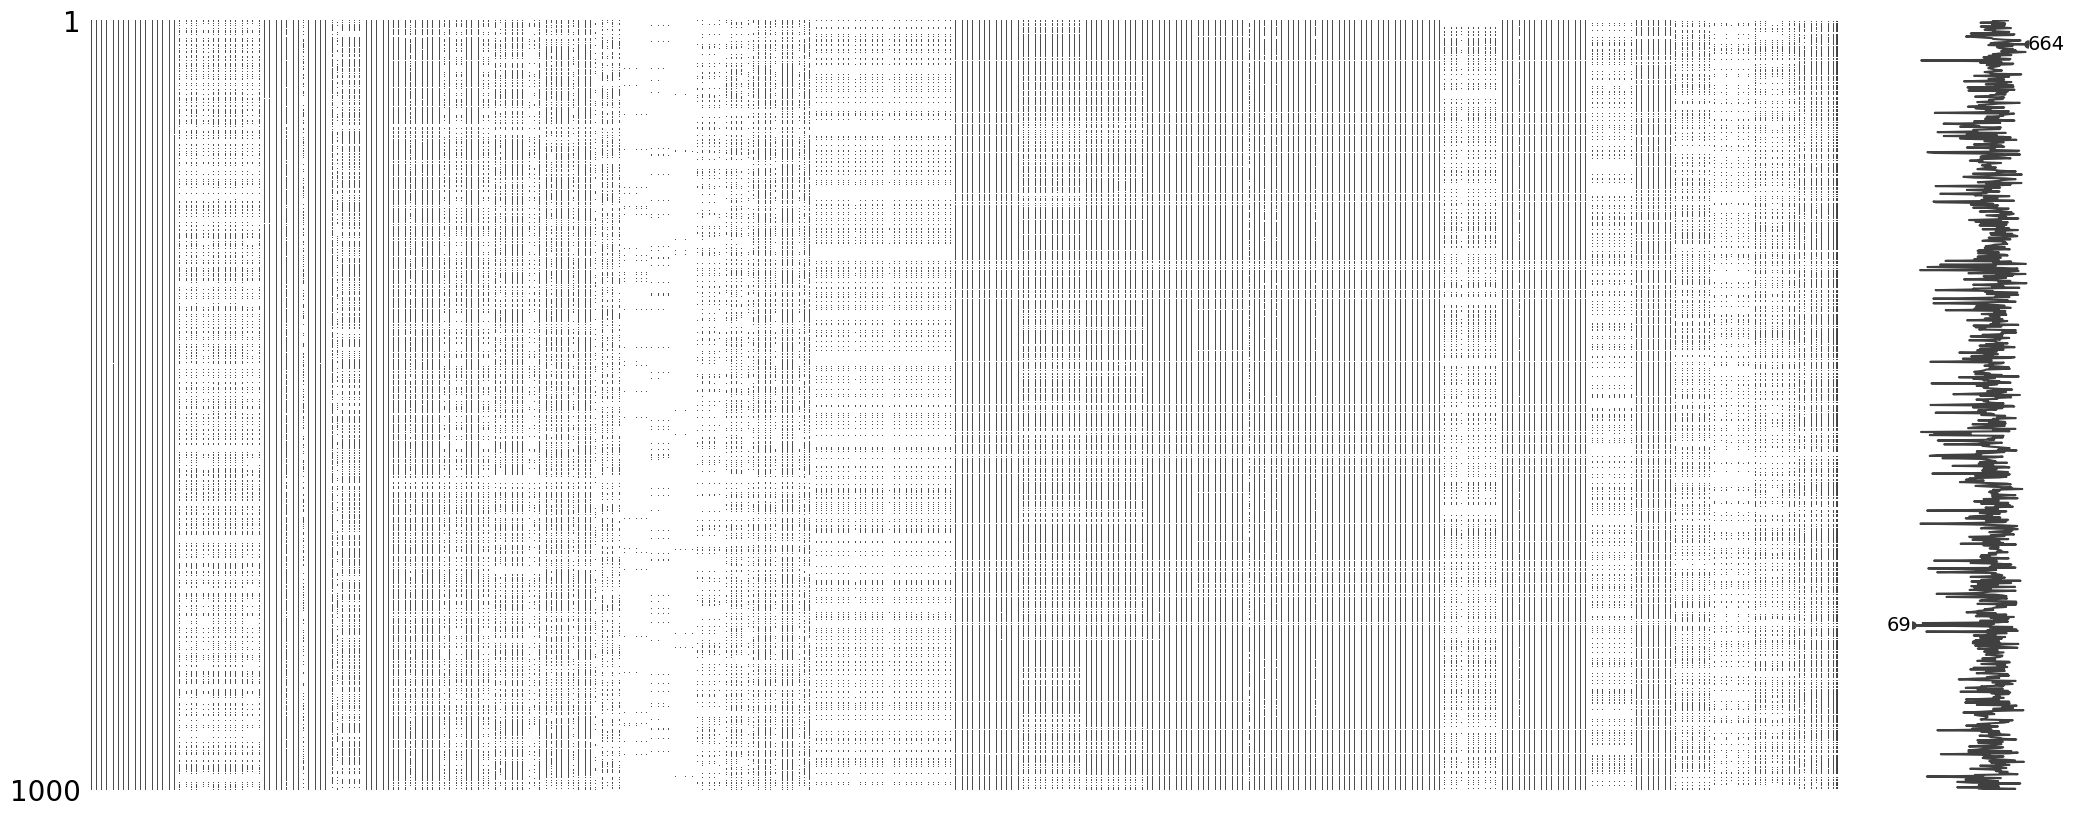

In [42]:
# Values presence on a sample
msno.matrix(df.sample(1000))
plt.show()

In [49]:
# complete columns and number
complete_cols = list(df.columns.values[df.notnull().mean() == 1])
print(complete_cols)
len(complete_cols)

['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_18', 'DOCUMENT_COUNT', 'NEW_DOC_KURT', 'AGE_RANGE', 'CREDIT_TO_INCOME_RATIO', 'INCOME_TO_BIRTH_RATIO', 'ID_TO_BIRTH_RATIO', 'CREDIT_TO_ANNUITY_GROUP', 'GROUP2_EXT_SOURCES_MEDIAN', 'GROUP2_INCOME_MEDIAN', 'GROUP2_CREDIT_TO_ANNUITY_MEDIAN', 'GROUP2_CREDIT_MEDIAN', 'GROUP2_ANNUITY_MEDIAN']


42

In [51]:
# content of complete columns
for col in complete_cols:
    print(f'{col} : {df[col].nunique()} uniques values')
    print(df[col].unique())

SK_ID_CURR : 356250 uniques values
[100002 100003 100004 ... 456223 456224 456250]
NAME_CONTRACT_TYPE : 2 uniques values
[0 1]
CODE_GENDER : 2 uniques values
[0 1]
FLAG_OWN_CAR : 2 uniques values
[0 1]
CNT_CHILDREN : 16 uniques values
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14 20]
AMT_INCOME_TOTAL : 2740 uniques values
[202500.  270000.   67500.  ... 271651.5  67905.  310122. ]
AMT_CREDIT : 6480 uniques values
[ 406597.5 1293502.5  135000.  ... 1005813.   477270.   511227. ]
NAME_INCOME_TYPE : 8 uniques values
[0 1 2 3 4 5 6 7]
NAME_EDUCATION_TYPE : 5 uniques values
[0 1 2 3 4]
NAME_FAMILY_STATUS : 6 uniques values
[0 1 2 3 4 5]
NAME_HOUSING_TYPE : 6 uniques values
[0 1 2 3 4 5]
REGION_POPULATION_RELATIVE : 82 uniques values
[0.0188   0.003542 0.01003  0.00802  0.02866  0.0358   0.003122 0.01863
 0.01968  0.0228   0.01522  0.03134  0.01662  0.01001  0.0207   0.01096
 0.04623  0.02516  0.006294 0.0264   0.01804  0.0191   0.03076  0.008575
 0.01884  0.006207 0.00918  0.007305 0.007114

# 8.  [&#9650;](#toc0_) <a id='toc8_'></a>Add extra ratio features

In [8]:
def add_ratio_features(df):
    """Add division between features - highly effective for GBDT models.

    Arguments:
        df: pandas DataFrame with features from all csv files

    Returns:
        df: Same DataFrame with the new features
    """
    df = df.copy()
    ratio_features = {
        # CREDIT TO INCOME RATIO
        'BUREAU_INCOME_CREDIT_RATIO':
            ['BUREAU_AMT_CREDIT_SUM_MEAN', 'AMT_INCOME_TOTAL'],
        'BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO':
            ['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM', 'AMT_INCOME_TOTAL'],
        # PREVIOUS TO CURRENT CREDIT RATIO
        'CURRENT_TO_APPROVED_CREDIT_MIN_RATIO':
            ['APPROVED_AMT_CREDIT_MIN', 'AMT_CREDIT'],
        'CURRENT_TO_APPROVED_CREDIT_MAX_RATIO':
            ['APPROVED_AMT_CREDIT_MAX', 'AMT_CREDIT'],
        'CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO': 
            ['APPROVED_AMT_CREDIT_MEAN', 'AMT_CREDIT'],
        # PREVIOUS TO CURRENT ANNUITY RATIO
        'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO':
            ['APPROVED_AMT_ANNUITY_MAX', 'AMT_ANNUITY'],
        'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO':
            ['APPROVED_AMT_ANNUITY_MEAN', 'AMT_ANNUITY'],
        'PAYMENT_MIN_TO_ANNUITY_RATIO':
            ['INS_AMT_PAYMENT_MIN', 'AMT_ANNUITY'],
        'PAYMENT_MAX_TO_ANNUITY_RATIO':
            ['INS_AMT_PAYMENT_MAX', 'AMT_ANNUITY'],
        'PAYMENT_MEAN_TO_ANNUITY_RATIO':
            ['INS_AMT_PAYMENT_MEAN', 'AMT_ANNUITY'],
        # BUREAU TO CURRENT ANNUITY RATIO
        'CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO':
            ['BUREAU_AMT_ANNUITY_MEAN', 'AMT_ANNUITY'],
        # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
        'CTA_CREDIT_TO_ANNUITY_MAX_RATIO':
            ['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX', 'CREDIT_TO_ANNUITY_RATIO'],
        'CTA_CREDIT_TO_ANNUITY_MEAN_RATIO':
            ['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN', 'CREDIT_TO_ANNUITY_RATIO'],
        # DAYS AND TIME DIFFERENCES AND RATIOS
        'DAYS_DECISION_MEAN_TO_BIRTH':
            ['APPROVED_DAYS_DECISION_MEAN', 'DAYS_BIRTH'],
        'DAYS_CREDIT_MEAN_TO_BIRTH':
            ['BUREAU_DAYS_CREDIT_MEAN', 'DAYS_BIRTH'],
        'DAYS_DECISION_MEAN_TO_EMPLOYED':
            ['APPROVED_DAYS_DECISION_MEAN', 'DAYS_EMPLOYED'],
        'DAYS_CREDIT_MEAN_TO_EMPLOYED':
            ['BUREAU_DAYS_CREDIT_MEAN', 'DAYS_EMPLOYED'],
        'HOUR_APPR_RATIO':
            ['HOUR_APPR_PROCESS_START', 'PREV_HOUR_APPR_PROCESS_START_MEAN'],
    }
    for ratio_feature, features in ratio_features.items():
        df[ratio_feature] = df[features[0]] / df[features[1]]
    # Hour: difference from previous applications
    df['HOUR_APPR_DIFFERENCE'] = df['HOUR_APPR_PROCESS_START'] - df['PREV_HOUR_APPR_PROCESS_START_MEAN']
    return df


def add_groupby_features(df):
    """Group some features by duration (credit/annuity) and extract the mean, median and std.

    Arguments:
        df: pandas DataFrame with features from all csv files

    Returns:
        df: Same DataFrame with the new features
    """
    g = 'CREDIT_TO_ANNUITY_RATIO'
    feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BUREAU_ACTIVE_DAYS_CREDIT_MEAN',
             'APPROVED_CNT_PAYMENT_MEAN', 'EXT_SOURCES_PROD', 'CREDIT_TO_GOODS_RATIO',
             'INS_DAYS_ENTRY_PAYMENT_MAX', 'EMPLOYED_TO_BIRTH_RATIO', 'EXT_SOURCES_MEAN',
             'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
    agg = df.groupby(g)[feats].agg(['mean', 'median', 'std'])
    agg.columns = pd.Index(['CTAR_' + e[0] + '_' + e[1].upper() for e in agg.columns.tolist()])
    df = df.join(agg, how='left', on=g)
    del agg
    gc.collect()
    return df

In [9]:
df = add_ratio_features(df)

In [10]:
df.shape

(356250, 737)

In [15]:
df.index = df.SK_ID_CURR
df = df.drop('SK_ID_CURR', axis=1)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0.467976,0.0,1.175170,1.175170,0.064052,0.092379,0.951172,1.372070,1.111328,1.000000
100003,0.0,0,1,0,0,270000.0,1293502.5,35698.5,1129500.0,1,...,1.813930,NaN,0.290785,0.239585,0.077841,0.083567,1.098633,1.179688,0.750000,-3.664062
100004,0.0,1,0,1,0,67500.0,135000.0,6750.0,135000.0,0,...,1.051282,NaN,0.187652,0.187652,0.042791,0.045521,3.623047,3.853516,1.799805,4.000000
100006,0.0,0,1,0,0,135000.0,312682.5,29686.5,297000.0,0,...,2.120394,NaN,2.643527,1.497926,0.018179,NaN,0.113647,NaN,1.159180,2.335938
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0.558600,NaN,0.931385,0.538762,0.061359,0.057646,0.402588,0.378174,0.891602,-1.335938


In [18]:
df.to_pickle(
    "./pickle_files/features.pkl.gz",
    compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1}
)